# Diffusion hyperparameter estimation
For optimal performance, we need to adjust two families of hyperparameters: the data reparametrization and the diffusion noise schedule. This notebook will guide you through that.

In [30]:
import torch
import gecco_torch
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from einops import rearrange
from torch import Tensor
from torch.utils.data import DataLoader


We assume that you have already created a config file with placeholder values. We load it to get access to the data module.

In [31]:
config = gecco_torch.load_config('../example_configs/neuron_unconditional.py')
data: pl.LightningDataModule = config.data
data.setup() # lightning data modules need to be setup before they can be used

Grab a couple of batches to estimate the data mean/std and find the optimal reparametrization parameters.

In [32]:
batches = []

dataloader: DataLoader = data.train_dataloader()

for i, batch in enumerate(dataloader):
    if i == 5: # break early to save time
        break
    batches.append(batch)

batches: gecco_torch.structs.Example = dataloader.collate_fn(batches) # [5, batch_size, ...]
batches = batches.apply_to_tensors(lambda t: t.reshape(-1, *t.shape[2:])) # [5 * batch_size, ...]

In [33]:
batches

Example(
 data=(240, 2048, 3),
 ctx=[],
)

Create a placeholder reparametrization and use it to estimate data statistics. If you're setting parameters for a UVL-parametrized model, simply change `GaussianReparam` to `UVLReparam` below and adjust the parameter names.

With `GaussianReparam` this step is not necessary since normalization with parameters mean=0, sigma=1 effectively does nothing. It is however important for `UVLReparam`.

In [34]:
placeholder_reparam = gecco_torch.reparam.GaussianReparam(
   mean=torch.zeros(3),
   sigma=torch.ones(3),
)

# placeholder_reparam = gecco_torch.reparam.UVLReparam(
#     mean=torch.zeros(3),
#     sigma=torch.ones(3),
# )

# placeholder_reparam = gecco_torch.reparam.NoReparam(dim=3)

diff_placeholder = placeholder_reparam.data_to_diffusion(batches.data, batches.ctx)

Compute mean/standard deviation of the data across the 3 axes and plot as histograms.

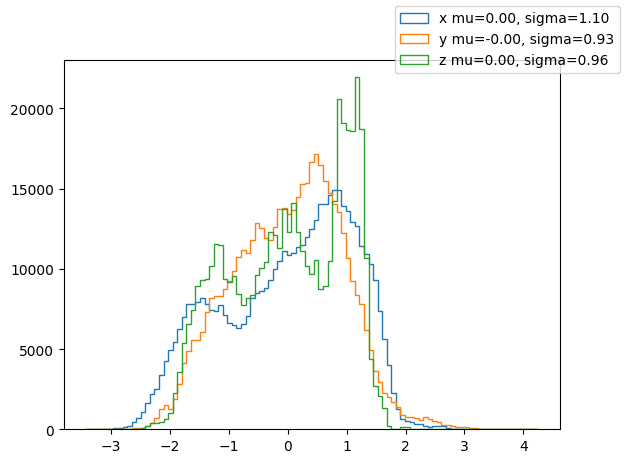

In [35]:
def data_statistics(data: Tensor) -> tuple[Tensor, Tensor]:
    x, y, z = data.unbind(-1)
    fig, ax = plt.subplots()
    kw = dict(histtype='step', bins=torch.linspace(data.min(), data.max(), 100))
    ax.hist(x.flatten(), label=f'x mu={x.mean().item():.02f}, sigma={x.std().item():0.2f}', **kw)
    ax.hist(y.flatten(), label=f'y mu={y.mean().item():.02f}, sigma={y.std().item():0.2f}', **kw)
    ax.hist(z.flatten(), label=f'z mu={z.mean().item():.02f}, sigma={z.std().item():0.2f}', **kw)
    fig.legend()

    mean = data.mean(dim=(0, 1))
    sigma = data.std(dim=(0, 1))

    return mean, sigma

mean_raw, sigma_raw = data_statistics(diff_placeholder)

## Reparametrization hyperparameters

Use the estimated parameters to compute the parameters to be used in your `config.py`. Copy-paste from the cell below.

In [36]:
adjusted_reparam = gecco_torch.reparam.GaussianReparam(mean=mean_raw, sigma=sigma_raw)
# adjusted_reparam = gecco_torch.reparam.UVLReparam(mean=mean_raw, sigma=sigma_raw)
print(adjusted_reparam)

GaussianReparam(mean=[1.3038515822572094e-09, -1.8626451769865326e-10, 1.4590720853746575e-09], sigma=[1.0994588136672974, 0.930317759513855, 0.9617206454277039])


Sanity check: use it on the data and visually check that the data is reasonably approximating the normal distribution.

(tensor([ 1.4280e-09, -1.2418e-10,  1.6919e-09]), tensor([1., 1., 1.]))

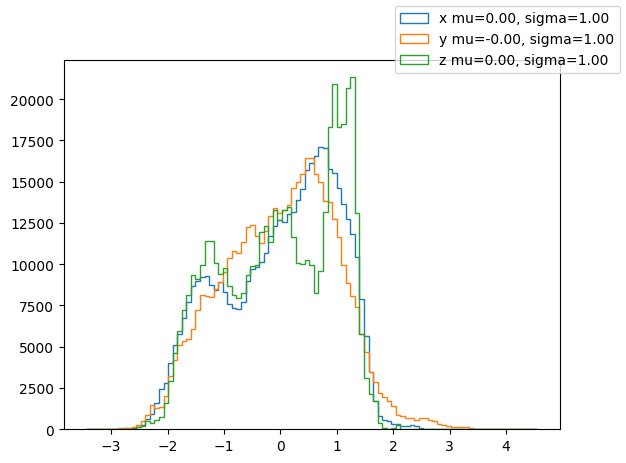

In [37]:
diff_adjusted = adjusted_reparam.data_to_diffusion(batches.data, batches.ctx)

data_statistics(diff_adjusted)

Now that the data is properly normalized we can take care of the noise schedule. A conservative rule of thumb is that we want to diffuse the data until every example (point cloud) can reasonably likely be confused for any other. This means that we want the $\sigma_{max}$ to be around the maximum pairwise distance between data examples. We compute the pairwise distance matrix and take the max.

There are two caveats: 
1. We're using only a subset of the dataset here, as computing the entire pairwise distance matrix would be prohibitive. We may therefore be underestimating this distance.
2. For conditional diffusion the conditioning signal can provide a lot of disambiguating information so there is no actual need to diffuse a car to the point of being confusable with an airplane. We may therefore be overestimating the value.

This is therefore just a rule of thumb for starting with a new dataset. You can likely get good results faster if you reduce this parameter afterwards.

The value to use for sigma_max of your noise schedule is 120.74237060546875.


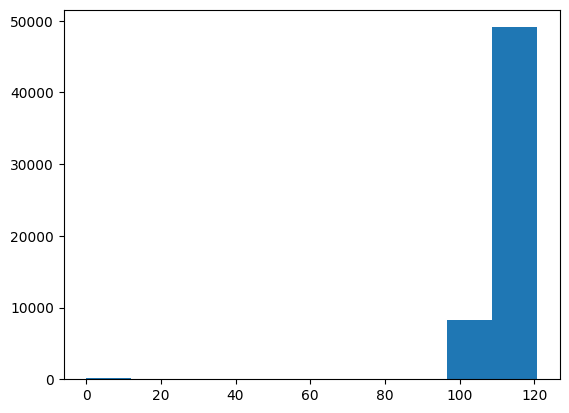

In [38]:
diff_flat = rearrange(diff_adjusted, 'b n d -> b (n d)')

distm = torch.cdist(diff_flat, diff_flat)
print(f'The value to use for sigma_max of your noise schedule is {distm.max().item()}.')
_ = plt.hist(distm.flatten()) # show a histogram of the distances for better intuition